# Building an LSTM model for price prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, optimizers

In [2]:
# Importing historical data downloaded from the Binance API
btcusdt_data_loc = "../Trading CSVs/BTCUSDT_historial_binance_2018-01-01_to_2020-11-27.csv"
btcusdt_df = pd.read_csv(btcusdt_data_loc)

In [3]:
mins_in_advance_to_predict = 30
window_length = 120

float_data = btcusdt_df['close'].values

### Preprocessing data

In [4]:
def format_data(data_in, mins_in_advance_to_predict, window_length):
    
    num_data_points = (len(data_in)-mins_in_advance_to_predict)//window_length
    
    X = [data_in[window_length*i : window_length*(i+1)]
                    for i in range(num_data_points)]
    Y = [data_in[window_length*(i+1) + mins_in_advance_to_predict] for i in range(num_data_points)]
    
    X_normalised, Y_normalised, means = [], [], []
    
    for i in range(num_data_points):
        X_i = np.array(X[i])
        X_i_mean = X_i.mean()
        
        # Dividing by mean of x[i]
        X_normalised.append(X_i/X_i_mean)
        Y_normalised.append(Y[i]/X_i_mean)
        
        # Saving the means for later use
        means.append(X_i_mean)
    
    X_normalised = np.array(X_normalised)
    X_normalised = X_normalised.reshape(*X_normalised.shape, 1)
    
    Y_normalised = np.array(Y_normalised)
    Y_normalised = Y_normalised.reshape(*Y_normalised.shape, 1)
    
    means = np.array(means)
    
    return X_normalised, Y_normalised, means

In [5]:
# Formatting and shuffling data
X_chronological, Y_chronological, means = format_data(float_data, mins_in_advance_to_predict, window_length)

shuffle_array = np.arange(len(X_chronological))
np.random.shuffle(shuffle_array)

X_shuffled = X_chronological[shuffle_array]
Y_shuffled = Y_chronological[shuffle_array]
means_shuffled = means[shuffle_array]

# To keep track of the data, if we want to refer back later
time_ints_shuffled = np.arange(len(float_data))[shuffle_array]

In [6]:
# Splitting into training and test data
test_split = 0.1
data_split_point = int(len(X_shuffled)*(1-test_split))

X_train = X_shuffled[:data_split_point].copy()
Y_train = Y_shuffled[:data_split_point].copy()
means_train = means_shuffled[:data_split_point].copy()

X_test = X_shuffled[data_split_point:].copy()
Y_test = Y_shuffled[data_split_point:].copy()
means_test = means_shuffled[data_split_point:].copy()

### Training

In [7]:
def build_model():
    model = models.Sequential()
    model.add(layers.LSTM(units = 64,
                          return_sequences = True,
                          dropout = 0.1,
                          recurrent_dropout=0.2,
                          input_shape = X_train.shape[1:]))
    model.add(layers.LSTM(units = 128,
                          return_sequences = True,
                          dropout = 0.1,
                          recurrent_dropout=0.2
                         ))
    model.add(layers.LSTM(units = 64,
                          return_sequences = True,
                          dropout = 0.1,
                          recurrent_dropout=0.2
                         ))
    model.add(layers.LSTM(units = 32,
                          dropout = 0.1,
                          recurrent_dropout=0.2
                         ))
    model.add(layers.Dense(units = 1))

    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    return model

model = build_model()

history = model.fit(X_train, Y_train, epochs = 4, batch_size = 32, validation_split=0.1)

Epoch 1/4
322/322 [==============================] - 131s 408ms/step - loss: 0.0086 - val_loss: 7.9873e-05
Epoch 2/4
322/322 [==============================] - 126s 390ms/step - loss: 4.2833e-04 - val_loss: 1.0299e-04
Epoch 3/4
322/322 [==============================] - 124s 387ms/step - loss: 2.3692e-04 - val_loss: 2.4701e-04
Epoch 4/4
322/322 [==============================] - 119s 370ms/step - loss: 1.6219e-04 - val_loss: 8.1217e-05


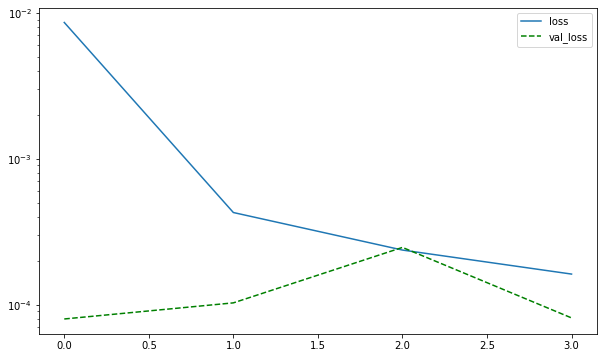

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], 'g--', label='val_loss')
plt.yscale('log')
plt.legend()
plt.show()

### Saving model

In [12]:
model.save("../models/LSTM/model_save")